In [1]:
# imports and constants
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.models import vgg16
import librosa
from IPython.display import Audio, display
from Data import MelSpecDataset, AudioDataset
from CNNModel import CNN

SAMPLE_RATE = 16000

In [ ]:
test_data = MelSpecDataset()


In [2]:
# load cnn model
cnn_model = CNN()
cnn_model.load_state_dict(torch.load('models/cnn_0_1.pth'))

<All keys matched successfully>

In [30]:
def cnn_predict(model, y, sr):
    y, _ = librosa.effects.trim(y, top_db=25)
    if len(y) < sr:
        return None 
    model.eval()
    category_scores = []
    for i in range(sr, len(y), sr // 2):
        S = librosa.feature.melspectrogram(y=y[i - sr: i], sr=sr, n_fft=512, win_length=400, hop_length=160)
        S = librosa.power_to_db(S)
        S = (S - S.min()) / (S.max() - S.min())
        S = torch.tensor(S).unsqueeze(0).unsqueeze(0)
        with torch.no_grad():
            category_scores.append(model(S).numpy())
    
    print(sum(category_scores))
    return ('ar', 'en', 'zh-TW')[np.argmax(sum(category_scores))]

In [33]:
# model demo
test_data = AudioDataset(SAMPLE_RATE)
(y, sr), language = test_data[np.random.randint(len(test_data))]

display(Audio(y, rate=sr))

prediction = cnn_predict(cnn_model, y, sr)
    
print('Prediction: ', prediction)
print('Actual: ', language)

[[-14.658603 -16.57585   14.143156]]
Prediction:  zh-TW
Actual:  zh-TW


In [ ]:
# test model
correct = 0
N = 1000
for i in range(N):
    while True:
        (y, sr), language = test_data[np.random.randint(len(test_data))]
        prediction = cnn_predict(cnn_model, y, sr)
        
        if prediction is None:
            continue
        
        if prediction == language:
            correct += 1
        break

print('Accuracy: ', correct / N)

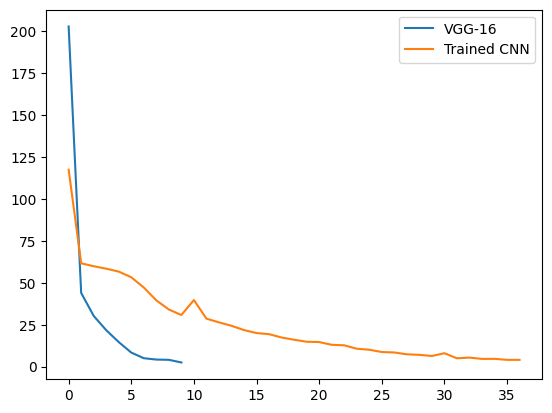

In [4]:
# plot loss convergence
vgg_losses = open('models/vgg_1_loss.txt', 'r').read().split('\n')
vgg_losses = [float(line.split()[-1]) for line in vgg_losses if line[:len('Epoch')] == 'Epoch']

cnn_losses = open('models/cnn_0_loss.txt', 'r').read().split('\n')
cnn_losses = [float(line.split()[-1]) for line in cnn_losses if line[:len('Epoch')] == 'Epoch']

plt.plot(vgg_losses)
plt.plot(cnn_losses)
plt.legend(['VGG-16', 'Trained CNN'])
plt.show()